# Vanishing Points and Lines
## Part 1
در این قسمت ابتدا به صورت اتوماتیک، خطوط را به دست می‌آوریم. برای به دست آوردن خطوط، ابتدا نیاز داریم تا با روش هاف، خطوط را به دست أوریم.

برای این منظور، پیش از شروع برای کاهش نویز، یک فیلتر گوسی اعمال می‌کنیم و  همچنین برای به دست آوردن نتیجه بهتر، درخت‌ها را جدا می‌کنیم. سپس برای از بین بردن تاثیر نویز‌گونه پنجره ساختمان‌ها در تشخیص خطوط،
یا یک کرنل بزرگ، روی عکس خاکستری، عمل مورفولوژی اپنینگ اعمال می‌کنیم. سپس خروجی به دست آمده را به $Canny$ می‌دهیم تا خطوط عکس به دست آیند.

پس از آن، با روش هاف، خطوط را به دست می‌آوریم. حال برای تشخیص دسته خطوط موازی، روی شیب خط‌ها به رادیان، با روش $Spectral Clustering$ خوشه‌بندی انجام می‌دهیم تا سه خوشه به دست آید.

سپس برای به دست‌ آوردن محل برخورد خطوط هر خوشه، آن‌ها را در یک دستگاه معادله قرار می‌دهیم و با روش کمترین مربعات، محل برخوردشان را پیدا میکنیم.

$
\begin{bmatrix}
\cos \theta_1 & \sin \theta_1\\
\cos \theta_2 & \sin \theta_2\\
\vdots & \vdots\\
\cos \theta_n & \sin \theta_n
\end{bmatrix}
\begin{bmatrix}
x_V\\
y_V
\end{bmatrix}
=
\begin{bmatrix}
\rho_1\\
\rho_2\\
\vdots\\
\rho_n\\
\end{bmatrix}
$

که در اینجا
$$x\cos\theta_i+y\sin\theta_i=\rho_i$$
معادله خطوط به دست آمده است.

در نهایت، با ضرب خارجی نقاط محو شدن $V_x,V_y$، نرمال صفحه افق در تصویر به دست می‌آید که معادل خط افق در عکس است.


In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering

img_o = plt.imread('./data/hw3/vns.jpg')[:, 600:]


def my_metric(p1, p2):
    d = np.linalg.norm(p1 - p2)
    return np.pi / 2 - min(d, np.pi - d)


def auto_detect_axis_lines(src, sigma=5, morph=23, canny1=120, canny2=3 * 120, rho=1, theta=np.pi / 180,
                           hough_thresh=110, l2=True):
    src = src.copy()
    src = cv.GaussianBlur(src, (sigma, sigma), 0)
    src = cv.cvtColor(src, cv.COLOR_RGB2GRAY)
    src = cv.morphologyEx(src, cv.MORPH_OPEN, np.ones((morph, morph), dtype=np.uint8))
    edges = cv.Canny(src, canny1, canny2, L2gradient=l2)
    lines = cv.HoughLines(edges, rho, theta, hough_thresh)

    dists = np.array([[my_metric(a[0, 1], b[0, 1]) for b in lines] for a in lines])
    labels = SpectralClustering(n_clusters=3, random_state=0, affinity='precomputed').fit_predict(dists)

    return lines[labels == 0], lines[labels == 1], lines[labels == 2]


def find_intersection_by_lines(lines):
    A = np.zeros((len(lines), 2))
    b = np.zeros(len(lines))
    for i in range(len(lines)):
        r, theta = lines[i][0]
        A[i, :] = np.cos(theta), np.sin(theta)
        b[i] = r
    return np.round(np.append(np.linalg.lstsq(A, b, rcond=None)[0], [1])).astype(np.int)


lines_y, lines_z, lines_x = auto_detect_axis_lines(img_o)
vx = find_intersection_by_lines(lines_x)
vy = find_intersection_by_lines(lines_y)
vz = find_intersection_by_lines(lines_z)
print('vx:', vx)
print('vy:', vy)
print('vz:', vz)

vx: [5122 1780    1]
vy: [-17839   2907      1]
vz: [  -966 -63735      1]


حال تصاویر خواسته شده را رسم می‌کنیم. متاسفانه، روش اتوماتیک کمی خطا دارد!

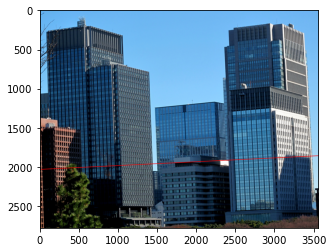

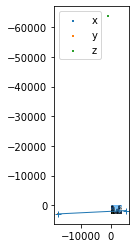

In [2]:
# res01
frame = img_o.copy()
cv.line(frame, (vx[0], vx[1]), (vy[0], vy[1]), (255, 0, 0), 6)
plt.imshow(frame)
plt.show()

# res02
plt.imshow(img_o)
plt.scatter(vx[0], vx[1], s=5, label='x', marker='+')
plt.scatter(vy[0], vy[1], s=5, label='y', marker='+')
plt.scatter(vz[0], vz[1], s=5, label='z', marker='+')
plt.plot([vx[0], vy[0]], [vx[1], vy[1]], linewidth=1, marker='+')
plt.legend()
plt.show()

